In [25]:
import pickle
import glob
import numpy as np
import pandas as pd
import distaz
import obspy
from scipy import interpolate
eqdir = '../transform_0to30/'
datatype='raw'
comp = 'BH*'
trimb = 20
trima = 80
eqs = open(''.join([eqdir,'EVENTS-INFO/event_list_pickle']),'rb')
eqs = pickle.load(eqs,encoding='bytes')
evid = []

ndep = 301
ndis = 131
dep = np.linspace(30,330,ndep)
dis = np.linspace(30,95,ndis)

pPdP = np.load('./tables/tele30to330.npy')
ftelep = interpolate.interp2d(dis, dep, pPdP, kind='linear')

ndep = 46
ndis = 651
dep = np.linspace(5,50,ndep)
dis = np.linspace(30,95,ndis)
sPdP = np.load('./tables/sSdS5to50.npy')
fppdp = interpolate.interp2d(dis, dep, sPdP, kind='linear')
fspdp = interpolate.interp2d(dis, dep, sPdP, kind='linear')

pPdP = np.load('./tables/teleS5to50.npy')
ftelep = interpolate.interp2d(dis, dep, pPdP, kind='linear')

for ii in eqs:
    evid.append(ii['event_id'])

evelist = glob.glob(eqdir+'/*a')
nevent = len(evelist)
irissta = pd.read_table('./tables/IRISSTA0319.txt',names=('net','sta','lat','lon'),\
                        header=0,delim_whitespace=True,keep_default_na=False)
for ievent in range(11,12):#nevent):
    ievent1 = ievent
    evname1 = evelist[ievent1].split('/')[-1]
    evidx1 = evid.index(evname1)
    evlat1 = eqs[evidx1]['latitude']
    evlon1 = eqs[evidx1]['longitude']
    evdep1 = eqs[evidx1]['depth']
    evtime1 = eqs[evidx1]['datetime']
    evmag1 = eqs[evidx1]['magnitude']
    stalist1 = glob.glob('/'.join([eqdir,evname1,datatype,'*.'+comp]))
    stalist = [stal.split('/')[-1] for stal in stalist1]
    print ('the',ievent,'th event of all ',nevent)
    print ('evinfo for eq:',evname1,evmag1,evlat1,evlon1,evdep1,len(stalist))
    nsta = len(stalist)
    stapos = np.zeros((nsta,2))
    idx = 0
    staposcl = np.zeros((nsta,2))
    for ista in range(nsta):
        stanet = stalist[ista].split('.')[0]
        staname = stalist[ista].split('.')[1]
        stasub = irissta[(irissta['net']==stanet) & (irissta['sta']==staname)]
        stlat = stasub.iloc[0]['lat']
        stlon = stasub.iloc[0]['lon']
        stapos[ista,0] = stlat
        stapos[ista,1] = stlon

    strmori = obspy.core.stream.Stream()

    idx = np.arange(nsta)
    for ista in range(len(idx)):
                stlat = stapos[idx[ista],0]
                stlon = stapos[idx[ista],1]
                dis1 = distaz.DistAz(evlat1,evlon1,stlat,stlon)
                trace = '/'.join([eqdir,evname1,datatype,stalist[idx[ista]]])

                strm = obspy.read(trace)
                tr = strm[0]
                parr = ftelep(dis1.delta,evdep1)[0]
                
                tr.stats.distance = dis1.delta#inc_angle
                tr.stats.baz = dis1.baz
                tr.trim(evtime1+parr-trimb,evtime1+parr+trima,pad=True,fill_value=0)
                tr.stats.starttime = 0
                strmori.append(tr)
  

the 11 th event of all  16
evinfo for eq: 20170818_025921.a 6.6 -1.0907 -13.6631 10.0 2353


In [25]:
from obspy.taup import TauPyModel
mod = TauPyModel(model='ak135')
arr = mod.get_travel_times(source_depth_in_km=10,distance_in_degree=30,phase_list=['ScS','PcS'])
for ii in range(1,len(arr)):
    print (arr[ii].name,arr[ii].time-arr[0].time)

print(arr)

ScS 234.18427782702747
2 arrivals
	PcS phase arrival at 774.221 seconds
	ScS phase arrival at 1008.405 seconds


In [11]:
arr0=arr[0]
arr0.name

'S'

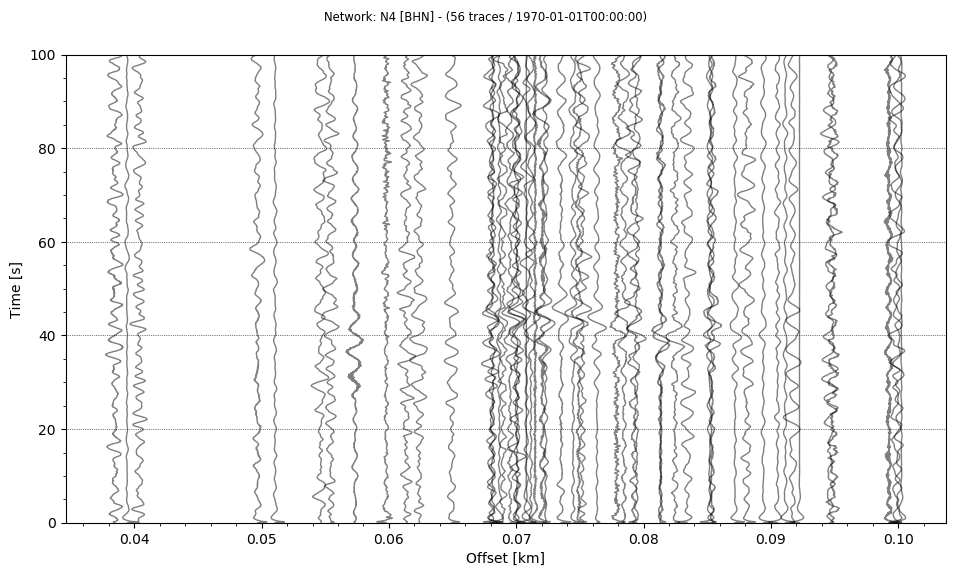

In [31]:
strmori2 = strmori.copy()
strmsub = strmori2.select(channel='BHN')
strmsub.filter('bandpass',freqmin=0.2,freqmax=4.0)
strmsub[::10].plot(type='section')

In [66]:
print(trace)
tracen = trace.split('.')[:-1]
tracen = '.'.join(tracen+['BHN'])
print (tracen)

../alaska5.6//20160723_095901.a/raw/CI.SHO..BHZ
../alaska5.6//20160723_095901.a/raw/CI.SHO..BHN


In [62]:
ndep = 46
ndis = 651
dep = np.linspace(5,50,ndep)
dis = np.linspace(30,95,ndis)
sPdP = np.load('./tables/sSdS5to50.npy')
fppdp = interpolate.interp2d(dis, dep, sPdP, kind='linear')
fspdp = interpolate.interp2d(dis, dep, sPdP, kind='linear')

pPdP = np.load('./tables/teleS5to50.npy')
ftelep = interpolate.interp2d(dis, dep, pPdP, kind='linear')

['', '', '/alaska5', '6//20160723_095901', 'a/raw/CI', 'SHO', '']


['', '', '/alaska5', '6//20160723_095901', 'a/raw/CI', 'SHO', '', 'BHN']

In [71]:
tt

1 Trace(s) in Stream:
CI.SLA..BHT | 2016-07-23T10:04:36.844538Z - 2016-07-23T10:08:46.844538Z | 40.0 Hz, 10001 samples

In [72]:
tt=strmsub.select(channel='BHT')
strmsub.remove(tt[0])
print (strmsub)

1 Trace(s) in Stream:
CI.SLA..BHR | 2016-07-23T10:04:36.844538Z - 2016-07-23T10:08:46.844538Z | 40.0 Hz, 10001 samples


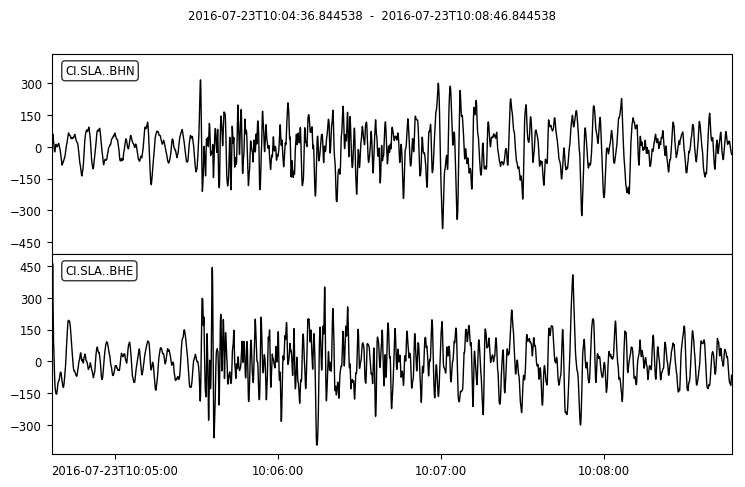

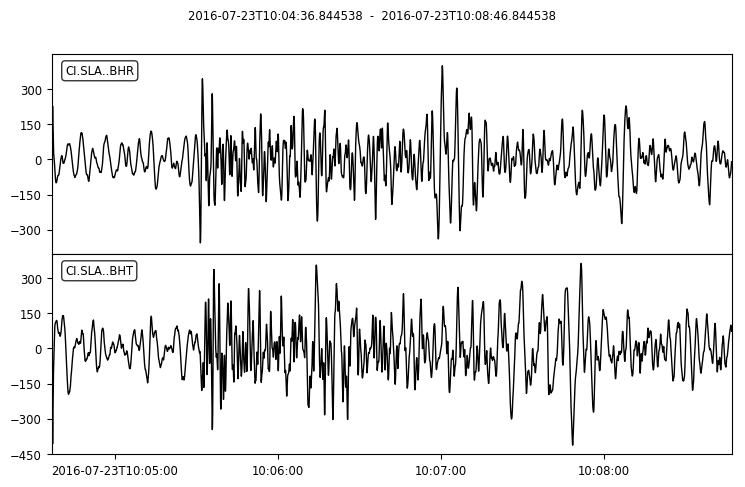

In [46]:
strmsub = strmori.select(station='SLA')
strmsub.remove(strmsub[1])
strmsub.filter('bandpass',freqmin=0.1,freqmax=2.0)
strmsub.plot()
strmsub.rotate('NE->RT',back_azimuth=strmsub[0].stats.baz)
strmsub.plot()

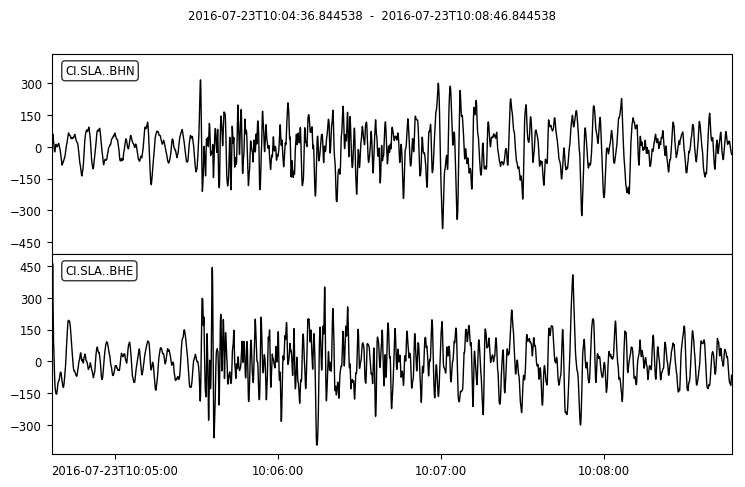

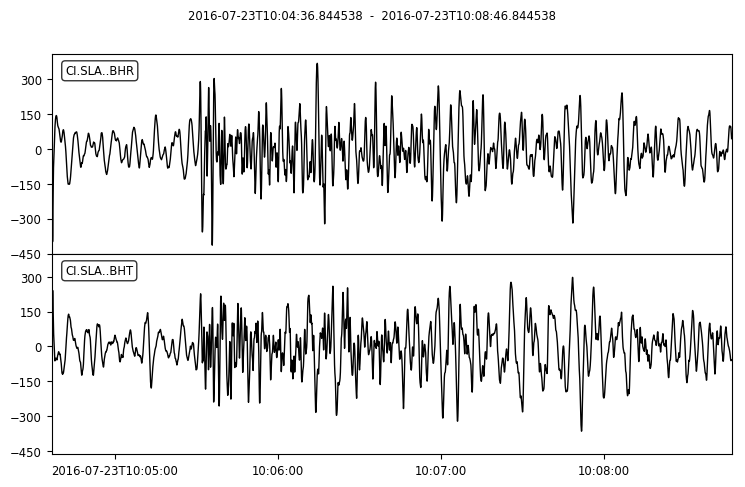

In [44]:
strmsub = strmori.select(station='SLA')
strmsub.remove(strmsub[1])
strmsub.filter('bandpass',freqmin=0.1,freqmax=2.0)
strmsub.plot()
strmsub.rotate('NE->RT',back_azimuth=strmsub[0].stats.baz)
strmsub.plot()

In [37]:
strmsub

3 Trace(s) in Stream:
CI.SLA..BHR | 2016-07-23T10:04:36.844538Z - 2016-07-23T10:08:46.844538Z | 40.0 Hz, 10001 samples
CI.SLA..BHZ | 2016-07-23T10:04:36.844538Z - 2016-07-23T10:08:46.844538Z | 40.0 Hz, 10001 samples
CI.SLA..BHT | 2016-07-23T10:04:36.844538Z - 2016-07-23T10:08:46.844538Z | 40.0 Hz, 10001 samples

In [20]:
print(strmori.__str__(extended=True))

171 Trace(s) in Stream:
CI.SLA..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.MWC..BHE    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.GMR..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.ISA..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.VES..BHN    | 2016-07-23T10:04:01.019536Z - 2016-07-23T10:25:40.994536Z | 40.0 Hz, 52000 samples
CI.MLAC..BHZ   | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.BAR..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.GLA..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.CIA..BHN    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z | 40.0 Hz, 52000 samples
CI.BAK..BHZ    | 2016-07-23T10:04:01.019538Z - 2016-07-23T10:25:40.994538Z |

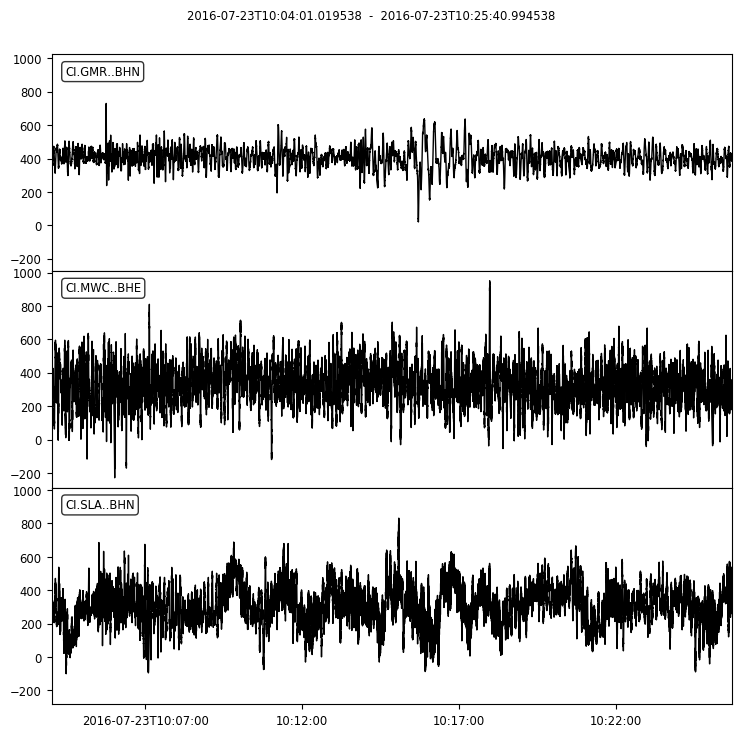

In [17]:
strmori[:3].plot()